<b>Name - H.M.P.Siriwardana<br>
Index- 190595J<br>
Assignment_02<br>

1

In [3]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import circle_fit as cf
import cv2 as cv
# np . random. seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )


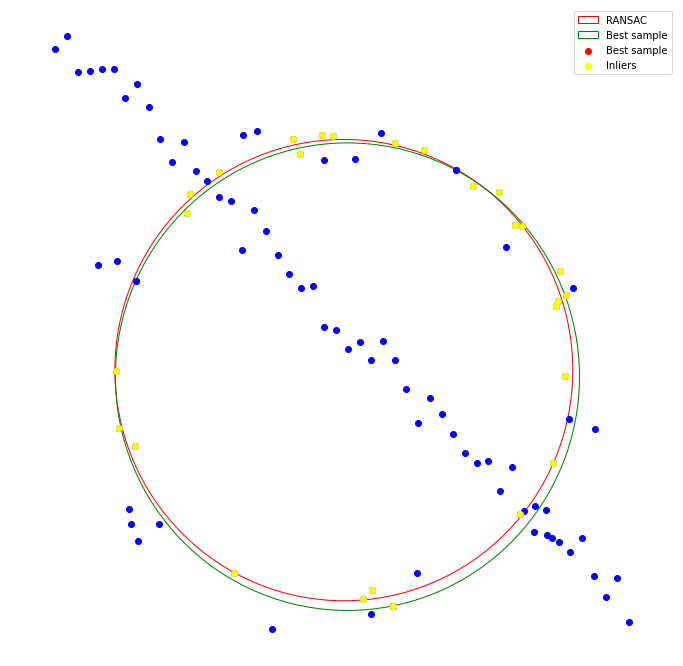

In [25]:
def Circle_RANSAC(points):
    threshold = np.std(points)/16  
    num_iter = np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**3)  
    iter_completed, max_inlierc, selected_model = 0, 0, None

    while iter_completed < num_iter:
        iter_completed += 1
        np.random.shuffle(points)  
        sample_points = points[:3]
        xc,yc,radius,_ = cf.least_squares_circle((sample_points)) 
        center = (xc, yc)
        error = np.abs(radius - np.sqrt(np.sum((center - points[3:])**2, axis=1))) 
        inliers = error <= threshold 
        inlier_c = np.count_nonzero(inliers)


        if inlier_c > max_inlierc: 
            max_inlierc = inlier_c
            inlier_points = []

            for index, inlier in enumerate(inliers): 
                if inlier == True:
                    inlier_points.append(points[3:][index])
            inlier_points = np.array(inlier_points)
            selected_model = (center, radius, sample_points, inlier_points)


    xc,yc,radius,_ = cf.least_squares_circle(np.concatenate((selected_model[2], selected_model[3]), axis=0))
    best_m = ((xc, yc), radius, selected_model[2], selected_model[3])
    return best_m 

best_m = Circle_RANSAC(X_circ)
xc,yc,r,_ = cf.least_squares_circle(best_m[2])

figure, ax = plt.subplots(figsize=(12, 12))
RASNSAC_circle = plt.Circle(best_m[0], best_m[1], fill=False, color='red', label='RANSAC')        
ax.add_artist(RASNSAC_circle)
circle = plt.Circle((xc, yc), r, fill=False, color='green', label='Best sample')    
ax.add_artist(circle)
ax.scatter(best_m[2][:, 0], best_m[2][:, 1], c='red', label='Best sample')
ax.scatter(X_circ[:, 0], X_circ[:, 1], c='blue')
ax.scatter(X_line[:, 0], X_line[:, 1], c='blue')
ax.scatter(best_m[3][:, 0], best_m[3][:, 1], c='yellow', label='Inliers')

plt.legend(loc=1)
plt.xlim(-14, 14)
plt.axis('off')
plt.show()

In [4]:
def click_event(event, x, y, flags, params):
    global coordinates
    global count
    global first_image

    if event == cv.EVENT_LBUTTONDOWN:
        coordinates.append([x, y])
        count += 1

        first_image = cv.circle(first_image, (x,y), 2, (0, 0, 1), -1)
        cv.imshow("Image", first_image)        
    
    if count == 4:
        cv.destroyAllWindows()
        cv.waitKey(1)

(-0.5, 975.5, 548.5, -0.5)

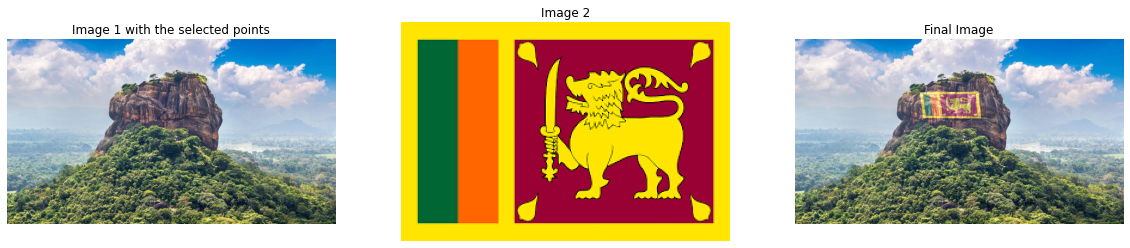

In [13]:
image_1 = cv.imread(r"Images/sigiriya.jpg")
image_2 = cv.imread(r"Images/sl_flag.png")

info = np.iinfo(image_1.dtype) 
image_1 = image_1.astype(np.float64) / info.max

info = np.iinfo(image_2.dtype) 
image_2 = image_2.astype(np.float64) / info.max

first_image = np.copy(image_1)

coordinates = []
count = 0

cv.imshow("Image", image_1)

cv.setMouseCallback("Image", click_event)
cv.waitKey(0)

if len(coordinates) < 4:
    print("You have selected less than 4 points. Please select 4 points")

cv.destroyAllWindows()

# Input parameters
X = np.array([
    [0, 0, 1],
    [image_2.shape[1], 0, 1],
    [image_2.shape[1], image_2.shape[0], 1],
    [0, image_2.shape[0], 1]
]).T

Y = np.array([
    [coordinates[0][0], coordinates[0][1], 1],
    [coordinates[1][0], coordinates[1][1], 1],
    [coordinates[2][0], coordinates[2][1], 1],
    [coordinates[3][0], coordinates[3][1], 1],
]).T

O = np.array([
    [0],
    [0],
    [0]
])

A = []

for i in range(4):
    A.append(np.concatenate((O.T, np.expand_dims(X.T[i,:], axis=0), np.expand_dims(-1*Y[1, i]*X.T[i,:], axis=0) ), axis=1))
    A.append(np.concatenate((np.expand_dims(X.T[i,:], axis=0), O.T, np.expand_dims(-1*Y[0, i]*X.T[i,:], axis=0) ), axis=1))

A = np.array(A).squeeze().astype(np.float64)

eigen_values, eigen_vectors = np.linalg.eig(A.T @ A)
H = eigen_vectors[:, np.argmin(eigen_values)]
H = H.reshape(3, -1)

t_image_2 = cv.warpPerspective(image_2, H, (image_1.shape[1], image_1.shape[0]))

beta = 0.5
blended_img = cv.addWeighted(image_1, 1, t_image_2, beta, 0.0)
blended_img[blended_img > 1] = 1

first_image_rgb = cv.cvtColor(first_image.astype(np.float32), cv.COLOR_BGR2RGB) 
image_2_rgb = cv.cvtColor(image_2.astype(np.float32), cv.COLOR_BGR2RGB)
blended_img_rgb = cv.cvtColor(blended_img.astype(np.float32), cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(first_image_rgb)
ax[1].imshow(image_2_rgb)
ax[2].imshow(blended_img_rgb)

ax[0].set_title("")
ax[1].set_title("Image 2")
ax[2].set_title("Final Image")

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

# 3

a

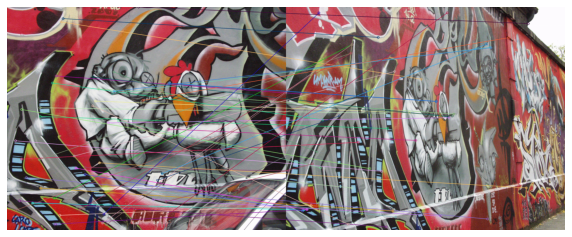

In [5]:
import cv2 as cv

img1, img2 = cv.imread(r"Images\graf\img1.ppm"), cv.imread(r"Images\graf\img5.ppm")
img1, img2 = cv.cvtColor(img1, cv.COLOR_BGR2RGB), cv.cvtColor(img2, cv.COLOR_BGR2RGB)


sift = cv.xfeatures2d.SIFT_create()

kp1, desc1 = sift.detectAndCompute(img1, None)
kp2, desc2 = sift.detectAndCompute(img2, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2)
good, pts1, pts2 = [], [], []

for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

good, pts1, pts2 = np.array(good), np.array(pts1), np.array(pts2)
matched_img = cv.drawMatchesKnn(img1, kp1, img2, kp2, good[:50], None, flags=2)

fig, ax = plt.subplots(figsize = (10, 10))
#ax.set_title('SIFT Feature Matching Between Graffiti Images')
ax.imshow(matched_img)
ax.axis('off')
#plt.savefig(r"Report\Images\31.png")
plt.show()

b

In [6]:
b

2